Description for which files are where, what is needed

### What you need

This tutorial goes from parsing data to visualizing the posterior of MDSINE2.

The tables that you will need are:
* taxa counts
* qPCR table
* perturbations table
* taxonomy table
* metadata file

Our data is preprocessed in objects from a previous tutorial. For this tutorial we unpacking our data into it's composite tables to walk you through constructing your own `Study` objects


In [1]:
!git clone https://github.com/gerberlab/MDSINE2_Paper
!git clone https://github.com/gerberlab/MDSINE2
!pip install MDSINE2/.

Cloning into 'MDSINE2_Paper'...
remote: Enumerating objects: 3241, done.
remote: Counting objects: 100% (813/813), done.
remote: Compressing objects: 100% (539/539), done.
remote: Total 3241 (delta 510), reused 524 (delta 265), pack-reused 2428
Receiving objects: 100% (3241/3241), 82.79 MiB | 16.66 MiB/s, done.
Resolving deltas: 100% (2050/2050), done.
Cloning into 'MDSINE2'...
remote: Enumerating objects: 2935, done.
remote: Counting objects: 100% (844/844), done.
remote: Compressing objects: 100% (563/563), done.
remote: Total 2935 (delta 565), reused 531 (delta 272), pack-reused 2091
Receiving objects: 100% (2935/2935), 78.18 MiB | 18.96 MiB/s, done.
Resolving deltas: 100% (1855/1855), done.
Processing ./MDSINE2
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will r

In [1]:
%matplotlib inline

import mdsine2 as md2
from mdsine2.names import STRNAMES
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path

In [2]:
output_dir = Path("MDSINE2_Paper/analysis/output/gibson-mini")
dataset_dir = output_dir / "datasets"

In [3]:
# Make example datasets from preprocessed data
def make_toy(dset):
    to_delete = []
    for taxon in dset.taxa:
        if taxon.idx >= 15:
            to_delete.append(taxon.name)
    dset.pop_taxa(to_delete)
    
    toy_dataset_path = dataset_dir / "{}-toy".format(dset.name)
    toy_dataset_path.mkdir(parents=True, exist_ok=True)
    
    dset.write_metadata_to_csv(path=toy_dataset_path / 'metadata.tsv')
    dset.write_qpcr_to_csv(path=toy_dataset_path / 'qpcr.tsv')
    if dset.perturbations is not None:
        dset.write_perturbations_to_csv(path=toy_dataset_path / 'perturbations.tsv')
    dset.write_reads_to_csv(path=toy_dataset_path / 'reads.tsv')
    dset.taxa.write_taxonomy_to_csv(path=toy_dataset_path / 'taxonomy.tsv')

In [4]:
healthy = md2.Study.load('MDSINE2_Paper/analysis/output/gibson/preprocessed/gibson_healthy_agg_taxa_filtered.pkl')
uc = md2.Study.load('MDSINE2_Paper/analysis/output/gibson/preprocessed/gibson_uc_agg_taxa_filtered.pkl')
replicates = md2.Study.load('MDSINE2_Paper/analysis/output/gibson/preprocessed/gibson_replicates_agg_taxa_filtered.pkl')

make_toy(dset=healthy)
make_toy(dset=uc)
make_toy(dset=replicates)

### Metadata table
The following table is a metadata table. It tells the `Study` object what subject and timepoint each sample belongs to

In [5]:
# Load metadata table
metadata = pd.read_csv(dataset_dir / 'healthy-toy' / 'metadata.tsv', sep='\t')
metadata.head()

,sampleID,subject,time
0,2-D10,2,10.0
1,2-D11,2,11.0
2,2-D14,2,14.0
3,2-D16,2,16.0
4,2-D18,2,18.0


### qPCR table
The following table is a qPCR table. This has the replicate measurements of the qPCR for every sample.

In [6]:
# qPCR table
qpcr = pd.read_csv(dataset_dir / 'healthy-toy' / 'qpcr.tsv', sep='\t')
qpcr.head()

,sampleID,measurement1,measurement2,measurement3
0,2-D10,4.129004e+10,6.423568e+10,8.384557e+10
1,2-D11,2.981363e+10,6.587538e+10,5.077812e+10
2,2-D14,1.647771e+10,7.104907e+10,2.498869e+10
3,2-D16,3.666487e+10,6.237899e+10,3.875999e+10
4,2-D18,4.523257e+10,2.320504e+10,2.330249e+10


### Perturbation table
The following table is a perturbation table. This tells the `Study` object which subject has a perturbation and when. There can be multiple perturbations for each subject. Note that this is only necessary if you have perturbations in your dataset.

In [7]:
perturbations = pd.read_csv(dataset_dir / 'healthy-toy' / 'perturbations.tsv', sep='\t')
display(perturbations)

,name,start,end,subject
0,High Fat Diet,21.5,28.5,2
1,High Fat Diet,21.5,28.5,3
2,High Fat Diet,21.5,28.5,4
3,High Fat Diet,21.5,28.5,5
4,Vancomycin,35.5,42.5,2
5,Vancomycin,35.5,42.5,3
6,Vancomycin,35.5,42.5,4
7,Vancomycin,35.5,42.5,5
8,Gentamicin,50.5,57.5,2
9,Gentamicin,50.5,57.5,3


### Reads table
The following table is a reads table. This shows the number of counts each taxa has for each sample ID.

In [8]:
reads = pd.read_csv(dataset_dir / 'healthy-toy' / 'reads.tsv', sep='\t')
reads.head()

,name,2-D10,2-D11,2-D14,2-D16,2-D18,2-D1AM,2-D1PM,2-D21AM,2-D21PM,2-D22AM,2-D22PM,2-D23AM,2-D23PM,2-D24,2-D25,2-D28AM,2-D28PM,2-D29AM,2-D29PM,2-D2AM,2-D2PM,2-D30AM,2-D30PM,2-D31AM,2-D31PM,2-D32,2-D33,2-D35AM,2-D35PM,2-D36AM,2-D36PM,2-D37AM,2-D37PM,2-D38,2-D39,2-D3AM,2-D3PM,2-D42AM,2-D42PM,...,5-D3AM,5-D3PM,5-D42AM,5-D42PM,5-D43AM,5-D43PM,5-D44AM,5-D44PM,5-D45AM,5-D45PM,5-D46,5-D47,5-D4AM,5-D4PM,5-D5,5-D50AM,5-D50PM,5-D51AM,5-D51PM,5-D52AM,5-D52PM,5-D53,5-D54,5-D57AM,5-D57PM,5-D58AM,5-D58PM,5-D59AM,5-D59PM,5-D6,5-D60AM,5-D60PM,5-D61,5-D62,5-D63,5-D64AM,5-D64PM,5-D7,5-D8,5-D9
0,OTU_1,1227,1793,8023,9503,3243,1830,199,3539,5270,3866,3899,1984,807,2299,1349,1074,855,3479,3910,489,1056,5113,5624,7096,5788,10237,2784,2711,2421,1554,1216,259,154,114,100,1474,3227,1963,2950,...,1198,3491,395,38,60,35,96,136,38,27,137,162,3943,5485,5746,49,103,39,80,222,205,115,29,73,135,140,223,83,192,6401,218,409,2072,1160,723,1043,1732,4698,3310,4495
1,OTU_2,17362,6887,17165,29854,36759,2929,9880,15863,20619,2725,1792,466,51,86,38,25,34,1317,2217,24422,17184,5490,5924,6906,7466,9783,7856,10490,9939,18164,17769,16694,8553,8842,5806,11193,15984,8567,6995,...,14848,19560,4414,4235,2542,2997,3094,4063,2390,3151,4671,10280,17736,21286,15239,8966,11075,9328,9982,11443,10228,1803,3863,3611,3487,2979,3613,4359,5351,16153,3483,5742,10560,6931,7609,9301,10964,14754,6195,7539
2,OTU_3,8162,4911,9743,5776,11136,213,555,8566,12664,21003,19170,19830,16629,14891,31789,15839,13884,10019,15779,878,4879,7562,9470,11915,16469,13191,9874,8836,6895,5094,14544,2291,1194,458,116,5842,8939,126,23,...,10501,5094,1038,31,19,18,34,73,8584,2989,3627,8577,7146,6964,9184,2135,1258,1001,1042,384,473,59,25,29,9,1,8,10,8,5602,7,51,2039,2944,9708,1664,2578,8830,3163,6160
3,OTU_4,3793,2713,2683,3423,5351,9,32,3815,6512,1091,617,215,318,273,551,366,209,2626,3040,205,264,4519,5056,4976,4818,1757,4139,5070,5575,7195,7188,18681,20984,13723,7217,203,371,3507,3929,...,522,939,2162,3243,3182,6006,6912,9189,8061,11804,18394,26639,1059,1343,1669,13609,16459,11413,10262,11874,11321,11560,9360,5699,3794,9114,8111,11557,11729,1477,8539,12437,15397,6717,4179,3597,5020,1395,895,2242
4,OTU_5,5852,3034,6870,6102,9957,2,7,4626,6412,691,503,197,388,172,289,162,186,2677,1548,71,84,1740,1395,2559,1266,2868,3018,2967,3276,9350,9143,707,313,77,350,895,1121,214,284,...,5,0,164,134,40,6,16,76,37,28,120,407,7,7,17,368,520,422,533,1282,2093,4278,2660,3503,3842,1051,1447,2867,3844,4320,1855,3481,5015,3096,2779,3302,1941,4893,2275,1903


### Taxonomy table
The following table is a taxonomy table. For each taxa name, it shows the sequence and taxonomy

In [9]:
taxonomy = pd.read_csv(dataset_dir / 'healthy-toy' / 'taxonomy.tsv', sep='\t')
display(taxonomy)

,name,sequence,kingdom,phylum,class,order,family,genus,species
0,OTU_1,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN
1,OTU_2,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis/ovatus
2,OTU_3,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,muciniphila
3,OTU_4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
4,OTU_5,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGGGTG...,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Parasutterella,excrementihominis
5,OTU_6,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,dorei/fragilis
6,OTU_7,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,caccae
7,OTU_8,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,salyersiae
8,OTU_9,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
9,OTU_10,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,uniformis


With these 5 tables, you can run our model. You can parse them directly into a `Study` object with the `mdsine2.dataset.parse` command:

In [10]:
h_toy = md2.dataset.parse(name='healthy-toy-dataset', 
                         taxonomy=dataset_dir / 'healthy-toy' / 'taxonomy.tsv', 
                         reads=dataset_dir / 'healthy-toy' / 'reads.tsv', 
                         qpcr=dataset_dir / 'healthy-toy' / 'qpcr.tsv', 
                         perturbations=dataset_dir / 'healthy-toy' / 'perturbations.tsv', 
                         metadata=dataset_dir / 'healthy-toy' / 'metadata.tsv')
uc_toy = md2.dataset.parse(name='uc-toy-dataset', 
                         taxonomy=dataset_dir / 'uc-toy' / 'taxonomy.tsv', 
                         reads=dataset_dir / 'uc-toy' / 'reads.tsv', 
                         qpcr=dataset_dir / 'uc-toy' / 'qpcr.tsv', 
                         perturbations=dataset_dir / 'uc-toy' / 'perturbations.tsv', 
                         metadata=dataset_dir / 'uc-toy' / 'metadata.tsv')
rep_toy = md2.dataset.parse(name='replicates-toy-dataset', 
                         taxonomy=dataset_dir / 'replicates-toy' / 'taxonomy.tsv', 
                         reads=dataset_dir / 'replicates-toy' / 'reads.tsv', 
                         qpcr=dataset_dir / 'replicates-toy' / 'qpcr.tsv', 
                         metadata=dataset_dir / 'replicates-toy' / 'metadata.tsv')


2021-09-27 13:47:36,281 [INFO] [base.py (1284)] - TaxaSet parsng new taxonomy table. Resetting
2021-09-27 13:47:36,446 [INFO] [base.py (1284)] - TaxaSet parsng new taxonomy table. Resetting
2021-09-27 13:47:36,643 [INFO] [base.py (1284)] - TaxaSet parsng new taxonomy table. Resetting


You would just read these in with this parser. These are identical to our precomputed dataset 

# Learning the Negative Binomial dispersion parameters

This corresponds to the script ``

words here

In [11]:
params = md2.config.NegBinConfig(
    seed=0, burnin=100, n_samples=200,
    checkpoint=100, 
    basepath=str(output_dir / "negbin")
)

description

In [12]:
mcmc_negbin = md2.negbin.build_graph(
    params=params, 
    graph_name=rep_toy.name, 
    subjset=rep_toy
)

2021-09-27 13:47:40,297 [INFO] [inference.py (591)] - Setting Single Write, Multiple Read Mode
2021-09-27 13:47:40,302 [INFO] [inference.py (596)] - Setting the trace of learned parameters
2021-09-27 13:47:40,303 [INFO] [inference.py (597)] - #######################################
2021-09-27 13:47:40,305 [INFO] [inference.py (599)] - Setting the trace of Negative binomial dispersion a0
2021-09-27 13:47:40,308 [INFO] [inference.py (599)] - Setting the trace of Negative binomial dispersion a1
2021-09-27 13:47:40,313 [INFO] [inference.py (599)] - Setting the trace of Filtering
2021-09-27 13:47:40,321 [INFO] [inference.py (601)] - Setting the trace for diagnostic variables
2021-09-27 13:47:40,323 [INFO] [inference.py (602)] - ##########################################


description

In [13]:
mcmc_negbin = md2.negbin.run_graph(
    mcmc_negbin, 
    crash_if_error=True
)

100%|██████████| 200/200 [00:01<00:00, 101.91it/s]
2021-09-27 13:47:43,771 [INFO] [inference.py (510)] - Inference total time: 0.009871625900268554/Gibb step
2021-09-27 13:47:43,773 [INFO] [inference.py (514)] - remove local traces


description, we are repeating this on the smaller dataset so you know how to run it and know what it looks like. This is not representative of the real results because we only have the ten most abundant taxa here.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


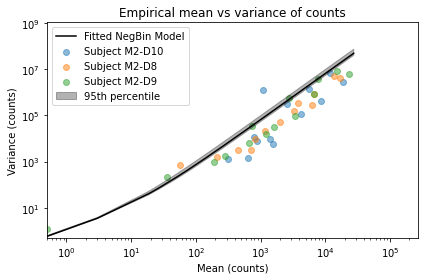

In [14]:
fig = md2.negbin.visualize_learned_negative_binomial_model(mcmc_negbin)
fig.tight_layout()

# Run the model

In [16]:
# Get a0 and a1 from negbin (get the mean of the posterior)
from mdsine2.names import STRNAMES
a0 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0])['mean']
a1 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1])['mean']

print('negbin a0', a0)
print('negbin a1', a1)

basepath = output_dir / "mdsine2" / "uc0"
basepath.mkdir(exist_ok=True, parents=True)

# Initialize parameters of the model (Seed = 0)
params = md2.config.MDSINE2ModelConfig(
    basepath=str(basepath), 
    seed=0,
    burnin=50, 
    n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50
)

# The default number of modules is 30, which is larger than the number of taxa
# that we have in this dataset, which would throw a flag.
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'

negbin a0 1.9940356992343302e-10
negbin a1 0.06562195000302486


In [17]:
# initilize the graph
mcmc_uc0 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)


2021-09-27 13:48:13,138 [INFO] [base.py (2775)] - max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
2021-09-27 13:48:13,167 [INFO] [run.py (87)] - Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
2021-09-27 13:48:13,365 [INFO] [run.py (254)] - There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
2021-09-27 13:48:13,376 [INFO] [run.py (289)] - Initializing Filtering
2021-09-27 13:48:13,378 [INFO] [posterior.py (2658)] - Setting up the essential timepoints
2021-09-27 13:48:13,381 [INFO] [posterior.py (2671)] - Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.
 11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5
 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5
 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5
 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5
 61.  62.  63.  64. 

In [18]:
mcmc_uc0 = md2.run_graph(mcmc_uc0, crash_if_error=True)

100%|██████████| 100/100 [01:08<00:00,  1.45it/s]
2021-09-27 13:49:25,867 [INFO] [inference.py (510)] - Inference total time: 0.688618688583374/Gibb step
2021-09-27 13:49:25,868 [INFO] [inference.py (514)] - remove local traces
2021-09-27 13:49:25,915 [INFO] [run.py (545)] - Denormalizing the parameters


2021-09-27 13:49:26,148 [INFO] [util.py (173)] - Number of clusters: 2
2021-09-27 13:49:26,152 [INFO] [util.py (179)] - Clusters assigned: [0 0 0 0 0 1 0 0 0 0 0 0 1 1 0]
Cluster 0
	 Bacteroidetes dorei/fragilis OTU_6
	 * Firmicutes OTU_16
	 Firmicutes intestini OTU_17
Cluster 1
	 * Bacteroidetes OTU_1
	 Bacteroidetes fragilis/ovatus OTU_2
	 Verrucomicrobia muciniphila OTU_3
	 * Bacteroidetes OTU_4
	 Proteobacteria excrementihominis OTU_5
	 Bacteroidetes caccae OTU_7
	 Bacteroidetes salyersiae OTU_8
	 * Bacteroidetes OTU_9
	 Bacteroidetes uniformis OTU_10
	 Bacteroidetes distasonis OTU_12
	 Bacteroidetes goldsteinii OTU_13
	 Bacteroidetes merdae OTU_18


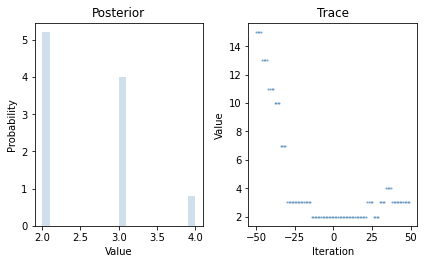

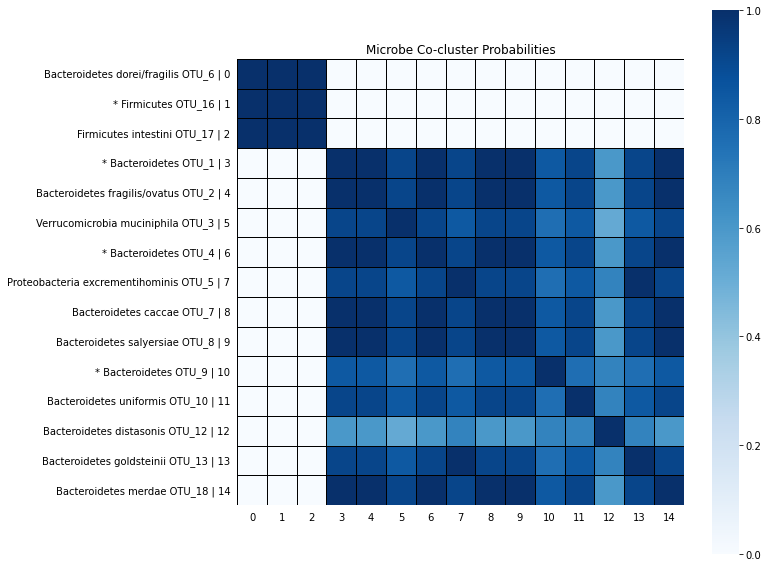

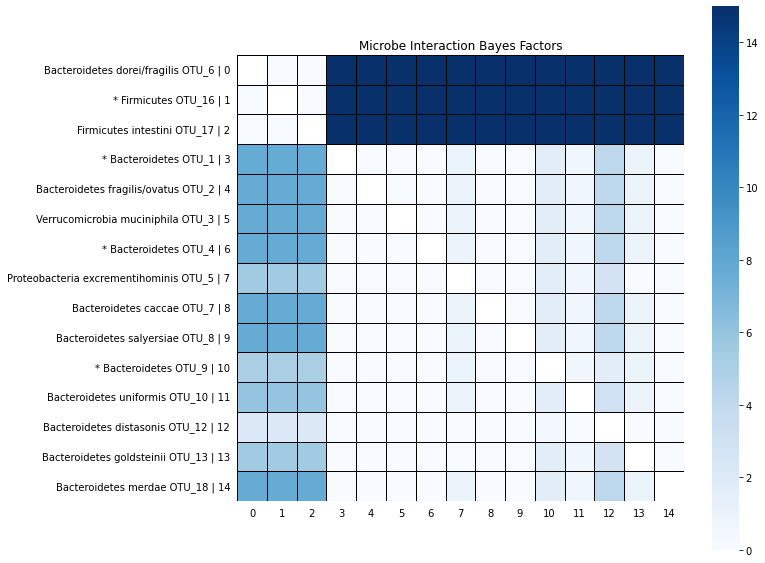

In [19]:
clustering = mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxa = mcmc_uc0.graph.data.taxa

md2.visualization.render_trace(clustering.n_clusters)
order = []
for i, cluster in enumerate(clustering):
    print('Cluster {}'.format(i))
    for oidx in cluster:
        print('\t', md2.taxaname_for_paper(taxa[oidx], taxa))
        order.append(oidx)

coclusters = md2.summary(mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_probabilities(coclusters, taxa=uc_toy.taxa,
    yticklabels='%(paperformat)s | %(index)s', order=order)

bayes_factors = md2.generate_interation_bayes_factors_posthoc(mcmc_uc0)
md2.visualization.render_bayes_factors(
    bayes_factors, taxa=taxa, yticklabels='%(paperformat)s | %(index)s',
    order=order)
plt.show()

# Calculating  $\hat{r}$

In [20]:
uc1_basepath = output_dir / 'mdsine2' / 'uc1'
uc1_basepath.mkdir(exist_ok=True)

params = md2.config.MDSINE2ModelConfig(
    basepath=uc1_basepath, 
    seed=1, 
    burnin=50, 
    n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc_uc1 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc_uc1 = md2.run_graph(mcmc_uc1, crash_if_error=True)


2021-09-27 13:49:27,658 [INFO] [base.py (2775)] - max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
2021-09-27 13:49:27,691 [INFO] [run.py (87)] - Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
2021-09-27 13:49:27,725 [INFO] [run.py (254)] - There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
2021-09-27 13:49:27,735 [INFO] [run.py (289)] - Initializing Filtering
2021-09-27 13:49:27,737 [INFO] [posterior.py (2658)] - Setting up the essential timepoints
2021-09-27 13:49:27,740 [INFO] [posterior.py (2671)] - Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.
 11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5
 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5
 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5
 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5
 61.  62.  63.  64. 

2021-09-27 13:50:37,338 [INFO] [util.py (173)] - Number of clusters: 3
2021-09-27 13:50:37,344 [INFO] [util.py (179)] - Clusters assigned: [0 0 0 0 0 1 1 0 2 0 2 0 1 1 1]
Cluster 0
	 * Bacteroidetes OTU_9
	 Bacteroidetes distasonis OTU_12
Cluster 1
	 * Bacteroidetes OTU_1
	 Bacteroidetes fragilis/ovatus OTU_2
	 Verrucomicrobia muciniphila OTU_3
	 * Bacteroidetes OTU_4
	 Proteobacteria excrementihominis OTU_5
	 Bacteroidetes salyersiae OTU_8
	 Bacteroidetes uniformis OTU_10
	 Bacteroidetes goldsteinii OTU_13
Cluster 2
	 Bacteroidetes dorei/fragilis OTU_6
	 Bacteroidetes caccae OTU_7
	 * Firmicutes OTU_16
	 Firmicutes intestini OTU_17
	 Bacteroidetes merdae OTU_18


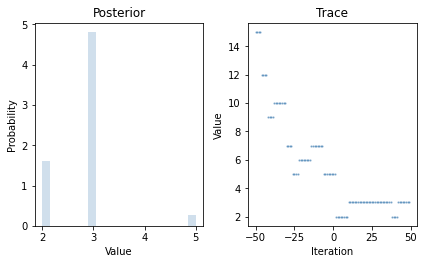

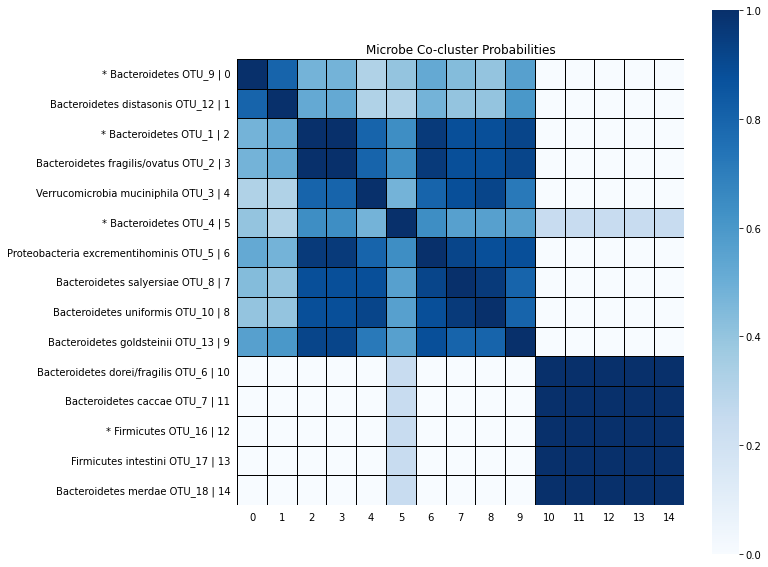

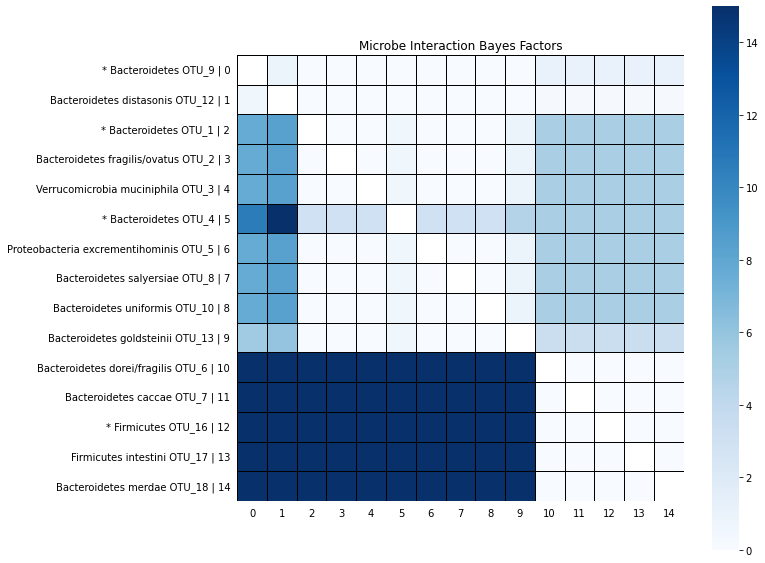

In [21]:
clustering = mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxa = mcmc_uc1.graph.data.taxa

md2.visualization.render_trace(clustering.n_clusters)
order = []
for i, cluster in enumerate(clustering):
    print('Cluster {}'.format(i))
    for oidx in cluster:
        print('\t', md2.taxaname_for_paper(taxa[oidx], taxa))
        order.append(oidx)

coclusters = md2.summary(mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_probabilities(
    coclusters, taxa=uc_toy.taxa, yticklabels='%(paperformat)s | %(index)s',
    order=order)

bayes_factors = md2.generate_interation_bayes_factors_posthoc(mcmc_uc1)
md2.visualization.render_bayes_factors(
    bayes_factors, taxa=taxa, yticklabels='%(paperformat)s | %(index)s',
    order=order)

plt.show()

In [22]:
chains = [mcmc_uc0, mcmc_uc1]
start = 10
end = 20
vname = STRNAMES.GROWTH_VALUE

rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Growth parameter r-hat:', rhat)

vname = STRNAMES.CONCENTRATION
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Concentration parameter r-hat:', rhat)

vname = STRNAMES.PROCESSVAR
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Process variance parameter r-hat:', rhat)


Growth parameter r-hat: [2.03354699 2.27293867 1.6792325  1.71052518 1.64383609 1.76505317
 1.65660989 1.64882678 1.65598663 1.66534829 2.28150285 1.66107476
 1.72406894 1.73453694 1.72608957]
Concentration parameter r-hat: [1.61910602]
Process variance parameter r-hat: [4.32587727]


# Consensus clustering
Run the model with a fixed modules

In [23]:
basepath = output_dir / 'mdsine2-fixed-cluster'
basepath.mkdir(exist_ok=True)

# Use the clustering from a previous as the clustering assignment
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# Do not learn the clustering parameters
params.LEARN[STRNAMES.CLUSTERING] = False
params.LEARN[STRNAMES.CONCENTRATION] = False

# Set the initialization option for clustering
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'fixed-clustering'
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value'] = str(uc1_basepath / "mcmc.pkl")

mcmc = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

2021-09-27 13:50:38,880 [INFO] [base.py (2775)] - max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
2021-09-27 13:50:38,907 [INFO] [run.py (87)] - Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
2021-09-27 13:50:38,942 [INFO] [run.py (254)] - There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
2021-09-27 13:50:38,952 [INFO] [run.py (289)] - Initializing Filtering
2021-09-27 13:50:38,954 [INFO] [posterior.py (2658)] - Setting up the essential timepoints
2021-09-27 13:50:38,958 [INFO] [posterior.py (2671)] - Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.
 11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5
 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5
 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5
 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5
 61.  62.  63.  64. 

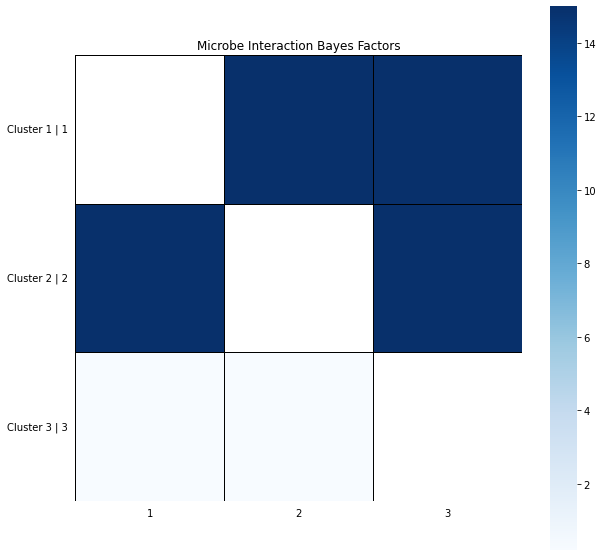

In [24]:
# Plot the posterior
clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
bf_taxa = md2.generate_interation_bayes_factors_posthoc(mcmc)
bf_clustering = md2.condense_fixed_clustering_interaction_matrix(bf_taxa, clustering=clustering)

labels = ['Cluster {} | {}'.format(i+1, i+1) for i in range(len(clustering))]
md2.visualization.render_bayes_factors(bf_clustering, yticklabels=labels)
plt.show()

# Cross validation

Take out a single subject and use that as initial conditions for forward simulation

In [25]:
# Make the data and validation Study objects
holdout_study = md2.dataset.parse(
    name='uc-toy-dataset', 
    taxonomy=dataset_dir / 'uc-toy' / 'taxonomy.tsv', 
    reads=dataset_dir / 'uc-toy' / 'reads.tsv', 
    qpcr=dataset_dir / 'uc-toy' / 'qpcr.tsv', 
    perturbations=dataset_dir / 'uc-toy' / 'perturbations.tsv', 
    metadata=dataset_dir / 'uc-toy' / 'metadata.tsv'
)

val = holdout_study.pop_subject('8')
val.name += '-validate'

print(holdout_study.name)
for subj in holdout_study:
    print(subj.name)
for pert in holdout_study.perturbations:
    print(pert)
print()
print(val.name)
for subj in val:
    print(subj.name)
for pert in val.perturbations:
    print(pert)


2021-09-27 13:51:40,104 [INFO] [base.py (1284)] - TaxaSet parsng new taxonomy table. Resetting
uc-toy-dataset
10
6
7
9
Perturbation High Fat Diet:
	Subject 6: (21.5, 28.5)
	Subject 7: (21.5, 28.5)
	Subject 9: (21.5, 28.5)
	Subject 10: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 6: (35.5, 42.5)
	Subject 7: (35.5, 42.5)
	Subject 9: (35.5, 42.5)
	Subject 10: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 6: (50.5, 57.5)
	Subject 7: (50.5, 57.5)
	Subject 9: (50.5, 57.5)
	Subject 10: (50.5, 57.5)


unnamed-study-validate
8
Perturbation High Fat Diet:
	Subject 8: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 8: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 8: (50.5, 57.5)



In [27]:
cv_output_dir = output_dir / "cv"

# Learn the model
params = md2.config.MDSINE2ModelConfig(
    basepath=cv_output_dir / holdout_study.name, 
    seed=0, 
    burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50
)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc = md2.initialize_graph(params=params, graph_name=holdout_study.name, subjset=holdout_study)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

2021-09-27 13:52:09,898 [INFO] [base.py (2775)] - max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
2021-09-27 13:52:09,922 [INFO] [run.py (87)] - Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
2021-09-27 13:52:09,953 [INFO] [run.py (254)] - There are 297 qPCR measurements for 3 buckets. Each bucket is 99 measurements long
2021-09-27 13:52:09,963 [INFO] [run.py (289)] - Initializing Filtering
2021-09-27 13:52:09,965 [INFO] [posterior.py (2658)] - Setting up the essential timepoints
2021-09-27 13:52:09,969 [INFO] [posterior.py (2671)] - Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.
 11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5
 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5
 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5
 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5
 61.  62.  63.  64.  

In [28]:
# Forward simulate

# Get the initial conditions
subj = val['8']
M_truth = subj.matrix()['abs']
initial_conditions = M_truth[:,0]
initial_conditions[initial_conditions==0] = 1e5
times = subj.times

# Forward simulate for each gibb step
M = md2.model.gLVDynamicsSingleClustering.forward_sim_from_chain(
    mcmc, subj=subj, 
    initial_conditions=initial_conditions, 
    times=times, 
    simulation_dt=0.01
)


2021-09-27 13:53:10,203 [INFO] [model.py (215)] - 5/50 - 0.5882484912872314
2021-09-27 13:53:10,770 [INFO] [model.py (215)] - 10/50 - 0.5645129680633545
2021-09-27 13:53:11,340 [INFO] [model.py (215)] - 15/50 - 0.5682954788208008
2021-09-27 13:53:11,921 [INFO] [model.py (215)] - 20/50 - 0.57846999168396
2021-09-27 13:53:12,490 [INFO] [model.py (215)] - 25/50 - 0.5670104026794434
2021-09-27 13:53:13,060 [INFO] [model.py (215)] - 30/50 - 0.5676209926605225
2021-09-27 13:53:13,622 [INFO] [model.py (215)] - 35/50 - 0.5605742931365967
2021-09-27 13:53:14,188 [INFO] [model.py (215)] - 40/50 - 0.5638742446899414
2021-09-27 13:53:14,731 [INFO] [model.py (215)] - 45/50 - 0.541083812713623


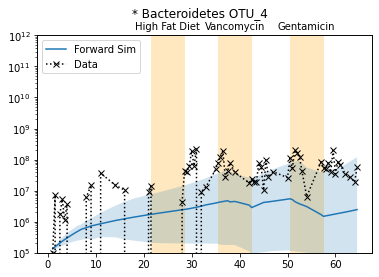

In [29]:
# Plot the forward sims, 25th-75th percentile
taxa = subj.taxa

low = np.percentile(M, q=25, axis=0)
high = np.percentile(M, q=75, axis=0)
med = np.percentile(M, q=50, axis=0)

oidx = 3

fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(times, y1=low[oidx, :], y2=high[oidx, :], alpha=0.2)
ax.plot(times, med[oidx,:], label='Forward Sim')
ax.plot(times, M_truth[oidx, :], label='Data', marker='x', color='black',
       linestyle=':')
ax.set_yscale('log')

md2.visualization.shade_in_perturbations(ax, perturbations=subj.perturbations, subj=subj)
ax.set_ylim(bottom=1e5, top=1e12)

ax.legend()

fig.suptitle(md2.taxaname_for_paper(taxa[oidx], taxa))
plt.show()